# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

[]

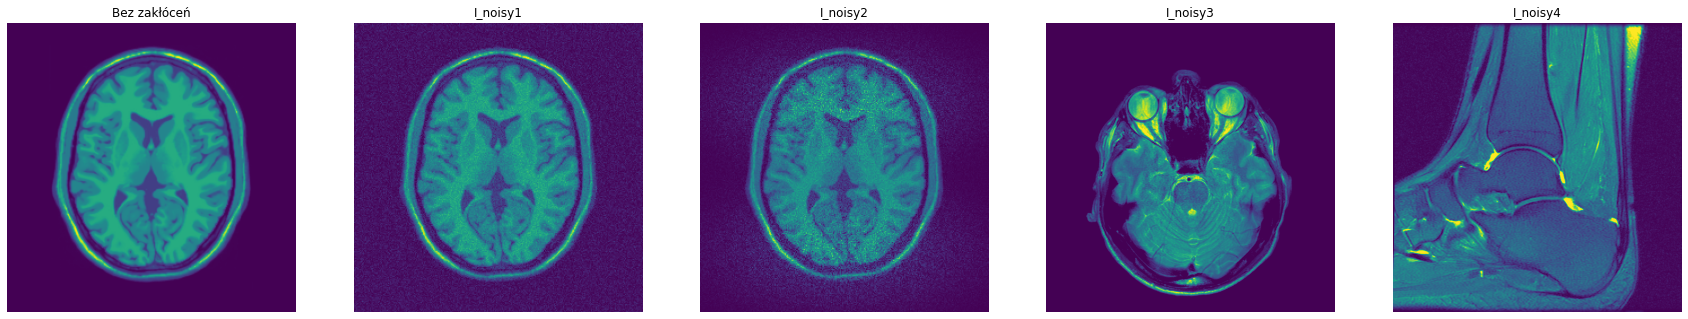

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
import cv2

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

#TODO Samodzielna


mat = loadmat('MR_data.mat')

mr0 = mat['I_noisefree']
mr1 = mat['I_noisy1']
mr2 = mat['I_noisy2']
mr3 = mat['I_noisy3']
mr4 = mat['I_noisy4']



figHist, axsHist = plt.subplots(1, 5)

figHist.set_size_inches(30, 20)
axsHist[0].imshow(mr0)
axsHist[0].axis('off')
axsHist[0].set_title('Bez zakłóceń')

axsHist[1].imshow(mr1)
axsHist[1].axis('off')
axsHist[1].set_title('I_noisy1')

axsHist[2].imshow(mr2)
axsHist[2].axis('off')
axsHist[2].set_title('I_noisy2')

axsHist[3].imshow(mr3)
axsHist[3].axis('off')
axsHist[3].set_title('I_noisy3')

axsHist[4].imshow(mr4)
axsHist[4].axis('off')
axsHist[4].set_title('I_noisy4')
plt.plot()


### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [2]:
#TODO Samodzielna
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 
    
    
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    ax.plot_surface(X, Y, Z)
    
    plt.show()


    
def n_pixel(frame, size = 5, sigma = 0.5):
    maska = fgaussian(size, sigma)
    W = 1/(np.sum(maska))
    Z = maska * frame
    out = W * np.sum(Z)
    return np.uint8(out)

def convolution(img, size = 5, sigma = 0.5):
    IConv = img.copy()
    n  = size //2
    (X_size, Y_size) = img.shape
    for x in range (n, X_size - n):
        for y in range (n, Y_size - n):
            frame = img[x-n : x+n+1, y - n : y+n+1]
            IConv[x, y] = n_pixel(frame, size, sigma)
    return IConv

Wizualizacja filtra; size = 5; sigma = 0.5


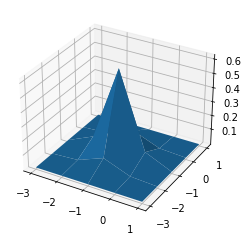

In [3]:
print('Wizualizacja filtra; size = 5; sigma = 0.5')
mesh(fgaussian(5, 0.5), 5)

In [4]:
mr0_1 = convolution(mr0)
mr1_1 = convolution(mr1)
mr2_1 = convolution(mr2)
mr3_1 = convolution(mr3)
mr4_1 = convolution(mr4)

mr0_abs = np.abs(mr0 - mr0_1)
mr1_abs = np.abs(mr1 - mr1_1)
mr2_abs = np.abs(mr2 - mr2_1)
mr3_abs = np.abs(mr3 - mr3_1)
mr4_abs = np.abs(mr4 - mr4_1)

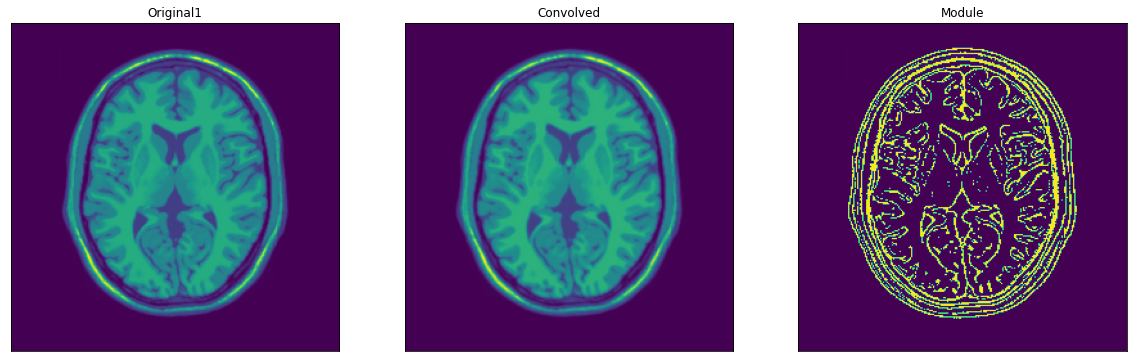

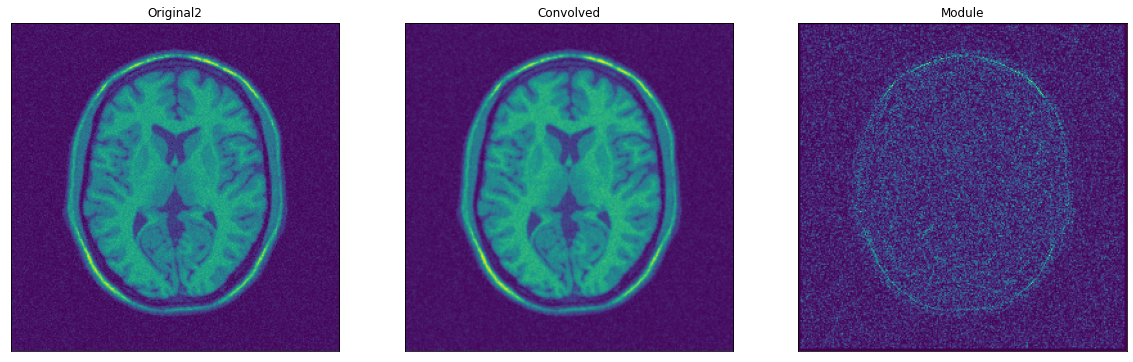

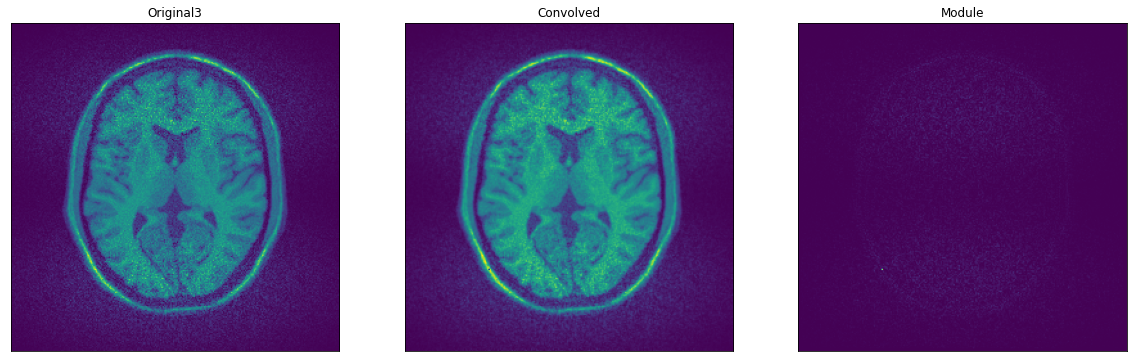

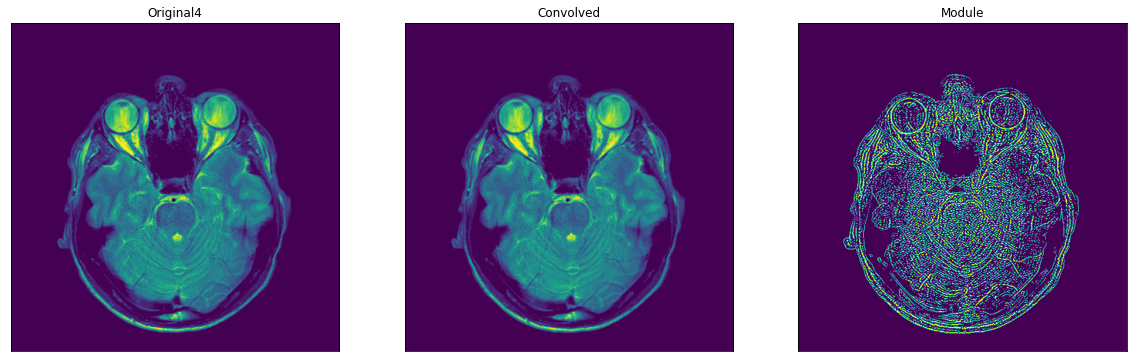

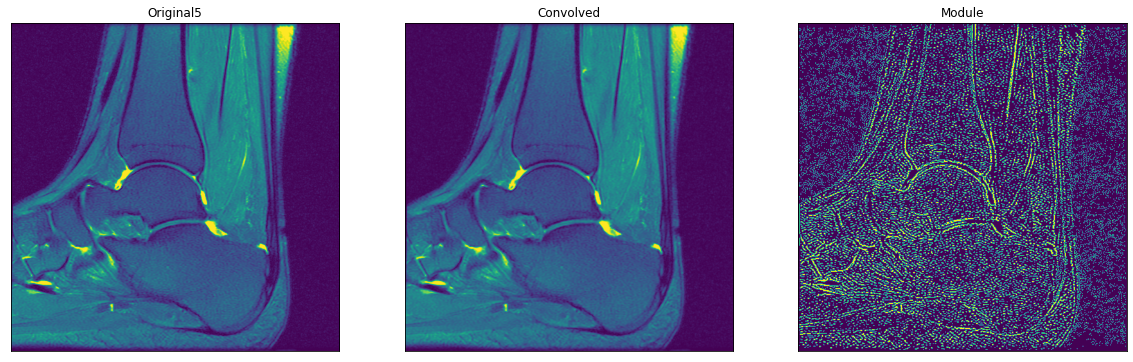

In [5]:
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr0),plt.title('Original1')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr0_1),plt.title('Convolved')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr0_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr1),plt.title('Original2')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr1_1),plt.title('Convolved')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr1_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr2),plt.title('Original3')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr2_1),plt.title('Convolved')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr2_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr3),plt.title('Original4')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr3_1),plt.title('Convolved')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr3_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr4),plt.title('Original5')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr4_1),plt.title('Convolved')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr4_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [6]:
def calc_gauss(frame, size = 5, R = 25):
    m = n = size
    h, k = m//2, n//2
    I = frame[h, k] * 1.0
    g = np.zeros((m, n))
    for x in range(0, size):
        for y in range(0, size):
            Ip = frame[x, y]
            diff  = Ip - I
            g[x, y] = np.exp(-(diff**2)/(2*R**2))
    return g 

    

def n_pixel_b(frame, size = 5, sigma = 0.5, R = 25):
    maska = fgaussian(size, sigma) 
    x = calc_gauss(frame, size, R)
    W = 1/(np.sum(maska))
    Z = maska * frame * x
    result = W * np.sum(Z)
    return result



def b_filtering(img, size = 5, sigma = 0.5, R = 25):
    output_img = img.copy()
    n  = size //2
    (size_x, size_y) = img.shape
    for x in range (n, size_x - n):
        for y in range (n, size_y - n):
            frame = img[x-n : x+n+1, y - n : y+n+1]
            output_img[x, y] = n_pixel_b(frame, size, sigma, R )
    return np.uint8(output_img)

In [7]:
mr0_2 = b_filtering(mr0)
mr1_2 = b_filtering(mr1)
mr2_2 = b_filtering(mr2)
mr3_2 = b_filtering(mr3)
mr4_2 = b_filtering(mr4)

mr0_abs = np.abs(mr0 - mr0_2)
mr1_abs = np.abs(mr1 - mr1_2)
mr2_abs = np.abs(mr2 - mr2_2)
mr3_abs = np.abs(mr3 - mr3_2)
mr4_abs = np.abs(mr4 - mr4_2)

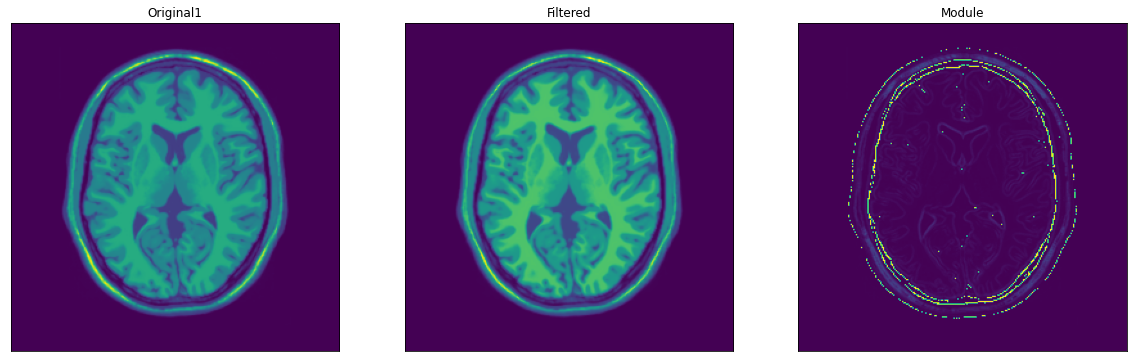

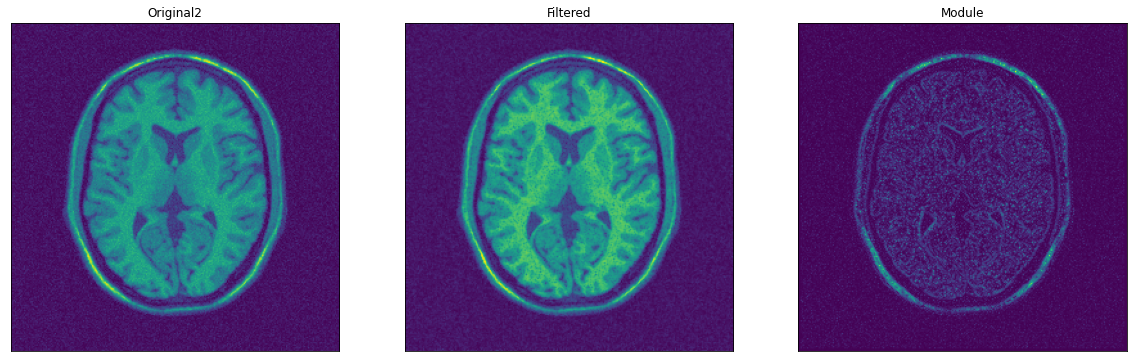

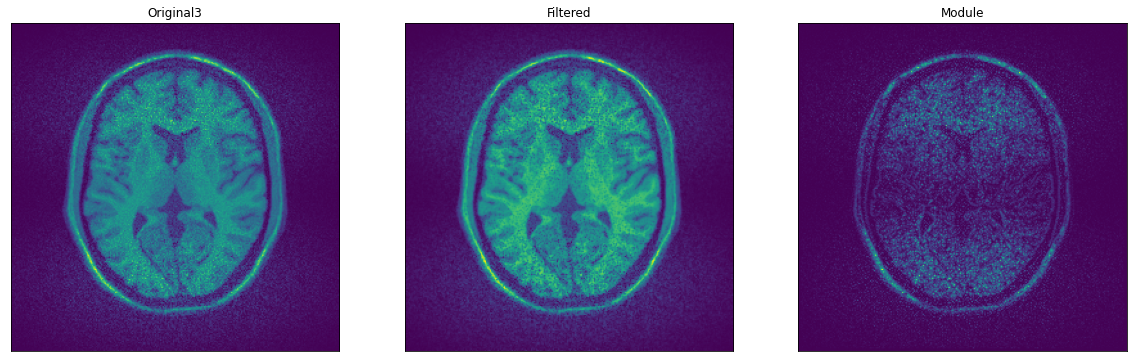

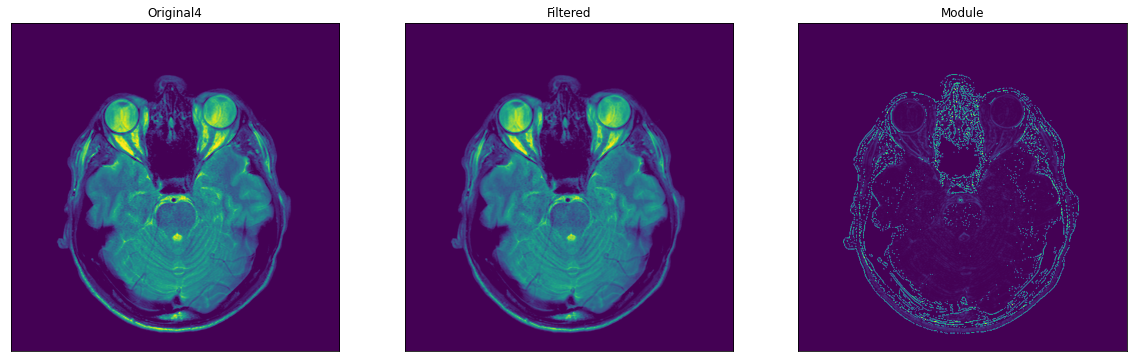

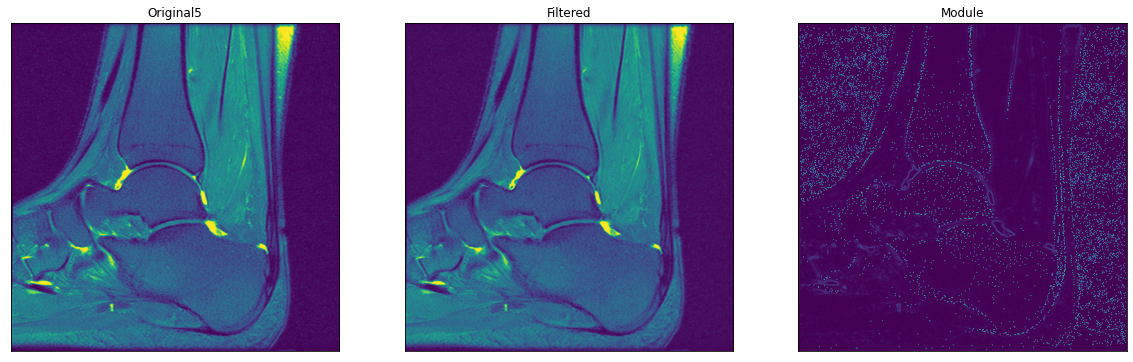

In [8]:
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr0),plt.title('Original1')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr0_2),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr0_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr1),plt.title('Original2')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr1_2),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr1_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr2),plt.title('Original3')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr2_2),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr2_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr3),plt.title('Original4')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr3_2),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr3_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()
f, ax = plt.subplots(1, 3, figsize = (20,20))
plt.subplot(131),plt.imshow(mr4),plt.title('Original5')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mr4_2),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mr4_abs),plt.title('Module')
plt.xticks([]), plt.yticks([])
plt.show()

Filtracja bilateralna jest najczęściej stosowana w brańży medycznej w celu uzyskania dokładnej interpretacji tomografii rezonansu magnetycznego.Filtracja bilateralna pozwala na dokładniejszą filtrację zaszumionego obrazu.
Utrata ostrości krawędzi na obrazach jest mniej widoczna.